# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
11974,18327,63279,NaN,21-03-2020,ÃÂLove one anotherÃÂ ?\r\r\n\r\r\nA good r...,Extremely Positive
13739,20474,65426,"Noida, India",22-03-2020,Demand for poultry grade maize has been hit o...,Negative
15414,22557,67509,"Hyderabad, India",23-03-2020,Hello sir How government was allowed the deliv...,Extremely Positive
9226,14996,59948,NaN,20-03-2020,@JacksonLeeTX18 Trump hopes sanctions+Covid-19...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
df['Sentiment'] = (df['Sentiment'].isin(['Negative', 'Extremely Negative'])).astype(int)

Сбалансированы ли классы?

In [4]:
print(np.bincount(df['Sentiment']))

[18046 15398]


**Ответ:** Классы соотносятся примерно как 0.85

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [5]:
df.isna().any().any()

True

In [6]:
df.fillna('Unknown', inplace=True)

In [7]:
df.isna().any().any()

False

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split ( df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [9]:
from collections import Counter

words = train['OriginalTweet'].tolist()
tokens = []
for i in words:
  tokens = tokens + i.lower().split()
res = Counter(tokens)
print(res)

Counter({'the': 26815, 'to': 23373, 'and': 14684, 'of': 13012, 'a': 11737, 'in': 11198, 'for': 8566, '#coronavirus': 8223, 'is': 7383, 'are': 7050, 'you': 5467, 'on': 5452, 'i': 5340, 'at': 4642, 'this': 4581, 'with': 4063, 'prices': 3891, 'food': 3820, 'we': 3787, 'have': 3770, 'that': 3741, 'as': 3694, 'be': 3570, 'grocery': 3469, 'supermarket': 3288, 'people': 3175, 'covid-19': 3173, 'store': 3155, 'it': 3150, 'from': 3045, 'all': 2808, 'your': 2784, 'will': 2726, 'not': 2714, '#covid19': 2471, 'our': 2460, 'my': 2445, '&amp;': 2314, 'they': 2309, 'has': 2304, 'consumer': 2245, 'by': 2236, 'or': 2234, 'can': 2202, 'but': 2159, 'if': 2142, '19': 2111, 'out': 2026, 'more': 2008, 'up': 1987, 'their': 1972, 'during': 1908, 'no': 1898, 'how': 1850, 'so': 1837, 'covid': 1769, 'get': 1759, 'about': 1726, 'who': 1670, '#covid_19': 1660, 'online': 1648, 'shopping': 1621, 'like': 1550, 'need': 1549, 'what': 1541, 'just': 1540, 'panic': 1495, '-': 1429, 'an': 1417, 'was': 1384, 'hand': 1382, '

Какой размер словаря получился?

In [10]:
len(res)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [11]:
res = dict(sorted(res.items(), key=lambda item: item[1], reverse=True))
for a, b in list(res.items())[:10]:
  print(a,b)

the 26815
to 23373
and 14684
of 13012
a 11737
in 11198
for 8566
#coronavirus 8223
is 7383
are 7050


**Ответ:** В топе артикли и предлоги (и один самый популярный хештег, но это исключение), без которых не обходится почти ни одно предложение

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [12]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)

True

In [13]:
res = {k: v for k, v in res.items() if k not in stopwords.words("english")}
for a, b in list(res.items())[:10]:
  print(a,b)

#coronavirus 8223
prices 3891
food 3820
grocery 3469
supermarket 3288
people 3175
covid-19 3173
store 3155
#covid19 2471
&amp; 2314


**Ответ:**  Остались хештэг и существительные, которые отражали самые популярные на тот момент темы

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [14]:
for a, b in list(res.items())[-21:-1]:
  print(a,b)

milion 1
skellig 1
coast! 1
closer!) 1
@skelligsix18 1
#skelligcoast2kms 1
#southkerry 1
https://t.co/zjcl195vqs 1
@srinivasiyc 1
https://t.co/iaek4fwsgz 1
premiership 1
non-playing 1
subsidise 1
playersãâ 1
renewing 1
wage! 1
flew 1
nothing... 1
@torontopearson 1
@680news 1


**Ответ:** Преимущественно это какие-то ссылки, теги и хэштеги, которые упоминаются не более одного раза, есть также слова с символами, не являющимися цифрами, знаками препинания или английскими буквами



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [15]:
from nltk.tokenize import TweetTokenizer

words = train['OriginalTweet'].tolist()
tokens = []
tw = TweetTokenizer()
for i in words:
  tokens = tokens + tw.tokenize(i)
res_tweet = Counter(tokens)

In [16]:
res_tweet = dict(sorted(res_tweet.items(), key=lambda item: item[1], reverse=True))
for a, b in list(res_tweet.items())[:10]:
  print(a,b)

the 24337
. 24118
to 22933
, 17571
and 14354
of 12904
a 11045
in 10573
? 9524
for 8228


**Ответ:** Новый топ отличается только тем, что в него попало несколько популярных знаков препинания, которые раньше не были отделены от слов методом сплит

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [17]:
from string import punctuation

noise = stopwords.words("english") + list(punctuation)
res_tweet = {k: v for k, v in res_tweet.items() if k not in noise}
for a, b in list(res_tweet.items())[:10]:
  print(a,b)

Â 7415
 7311
19 7167
#coronavirus 7143
I 5235
 4372
prices 4281
COVID 4218
food 3795
store 3691


**Ответ:** Многие слова оказались уже знакомыми, однако есть несколько странных символов

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [18]:
res_tweet = {k: v for k, v in res_tweet.items() if len(k) > 1 and ord(k[0]) < 128}
for a, b in list(res_tweet.items())[:10]:
  print(a,b)

print()

for a, b in list(res_tweet.items())[-21:-1]:
  print(a,b)

19 7167
#coronavirus 7143
prices 4281
COVID 4218
food 3795
store 3691
supermarket 3373
grocery 3083
people 3047
The 2516

https://t.co/5cBLIqZX7L 1
ruins 1
now.When 1
milion 1
Skellig 1
@SkelligSix18 1
#SkelligCoast2kms 1
#SouthKerry 1
https://t.co/zJcL195VQS 1
@srinivasiyc 1
https://t.co/IAEK4fWsgz 1
Vile 1
premiership 1
non-playing 1
subsidise 1
playersÃ 1
renewing 1
flew 1
@TorontoPearson 1
@680NEWS 1


**Ответ:** Топ популярных токенов очень похож на предыдущий, но имеет отдельный токен "19", а также, например, здесь не удален токен "The". В топе непопулярных слов есть одинаковые позиции, однако теперь слова с ныне отделенными знаками препинания уже не встречаются в нем.


Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [19]:
res_tweet_hashtag = {k: v for k, v in res_tweet.items() if k[0]=="#"}
for a, b in list(res_tweet_hashtag.items())[:10]:
  print(a,b)

#coronavirus 7143
#COVID19 1844
#Covid_19 1463
#Coronavirus 1281
#COVID2019 927
#toiletpaper 657
#covid19 568
#COVID 542
#CoronaCrisis 426
#CoronaVirus 351


**Ответ:** Они буквально все об одной теме (или почти об одной),в целом, ожидаемо

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [20]:
res_tweet_links = {k: v for k, v in res_tweet.items() if k[0:12]=="https://t.co"}
for a, b in list(res_tweet_links.items())[:10]:
  print(a,b)

https://t.co/oXA7SWtoNd 5
https://t.co/gP3EusapL8 4
https://t.co/DefTruI1PfÃÂ 3
https://t.co/WrLHYzIzAA 3
https://t.co/kuwIpF1KQW 3
https://t.co/zjNRx6dKKN 3
https://t.co/3GBBDpdjat 3
https://t.co/e2ZNXajPre 3
https://t.co/CATKegAyOY 3
https://t.co/G63RP042HO 3


**Ответ:** Топ популярных ссылок оказался не очень популярным:( Наверное, это не самая полезная информация для анализа

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [21]:
def custom_tokenizer(text):
  words = text.split()
  tokens = []
  tw = TweetTokenizer()
  for i in words:
    tokens = tokens + tw.tokenize(i.lower())
  tokens = {k for k in tokens if not(ord(k[0]) >= 128 and len(k) == 1) and ("t.co/" not in k) and k not in noise}

  return list(tokens)


In [22]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['#sampletext', 'text', 'sample', '@sample_text']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [23]:
from sklearn.feature_extraction.text import CountVectorizer


words = train['OriginalTweet'].tolist()
cv = CountVectorizer(tokenizer=custom_tokenizer)
res = cv.fit_transform(words)
print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** Пропала где-то треть токенов

Посмотрим на какой-нибудь конкретный твитт:

In [24]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 1)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [25]:
french_token = cv.fit_transform([train.iloc[ind]['OriginalTweet']])
res_french_token = dict(sorted(cv.vocabulary_.items(), key=lambda item: item[1], reverse=True))
print(res_french_token)

{'show': 13, 'queueing': 12, 'ppl': 11, 'panic': 10, 'one': 9, 'nice': 8, 'lets': 7, 'france': 6, 'food': 5, 'ffs': 4, 'brainless': 3, '@skynews': 2, '#covid2019': 1, '#coronavirusoutbreak': 0}


**Ответ:** В выведенном отсортированном списке мы можем увидеть весь вектор, где первая пара - самый важный токен 'show' и значение компоненты (13), а последний токен - пара с наименьшей ненулевой компонентой и значением '#covid2019'. В целом мы можем утверждать что они определились не очень хорошо, потому что слово 'show' почти никакой информации о твите не дает

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(tokenizer=custom_tokenizer)
french_token_tv = tv.fit_transform([train.iloc[ind]['OriginalTweet']])
res_french_token_tv = dict(sorted(tv.vocabulary_.items(), key=lambda item: item[1], reverse=True))
print(res_french_token_tv)

{'show': 13, 'queueing': 12, 'ppl': 11, 'panic': 10, 'one': 9, 'nice': 8, 'lets': 7, 'france': 6, 'food': 5, 'ffs': 4, 'brainless': 3, '@skynews': 2, '#covid2019': 1, '#coronavirusoutbreak': 0}


**Ответ:**

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [27]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)].head(20)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
10852,16964,61916,Limerick,21-03-2020,Its amazing. Greed is actually going to get us...,1
25998,35649,80601,London // Crawley,07-04-2020,Did you know 6 bus drivers have died from Covi...,1
6972,12278,57230,Unknown,19-03-2020,Listen this COVID-19 sucks but holy fuck these...,1
8044,13573,58525,house of balloons,20-03-2020,"after this covid-19 mess is over with, all mem...",1
31066,42019,86971,"Kennington, London",11-04-2020,To those who will inevitably whinge tomorrow a...,1
12099,18472,63424,Unknown,21-03-2020,Big shoutout to the supermarket staff keeping ...,1
5637,10646,55598,London/Oxford/Liverpool/Russia,19-03-2020,There are so many people who need to see this....,1
17086,24592,69544,"London, England",25-03-2020,shavedonatenominate\r\r\n\r\r\nThe government ...,1


Из нескольких твитов переберем некоторые из них и определим самый показательный для этого примера:

In [28]:
good_tweet = train.loc[[5637]]

In [29]:

good_tweet_tv = tv.fit_transform(good_tweet['OriginalTweet'])
print("Сам словарь:", tv.vocabulary_)
weights = good_tweet_tv.toarray()[0]
important_token = tv.get_feature_names_out()[np.argmax(weights)]
print("Важный токен:", important_token)


Сам словарь: {'many': 3, 'selfishness': 9, 'idiocy': 2, 'need': 5, 'people': 6, 'angry': 1, 'amazing': 0, 'woman': 10, 'see': 8, 'peopleã': 7, 'meanwhile': 4}
Важный токен: amazing


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


**Ответ:** TfidfVectorizer очень хорошо выделил важный токен, который(если используется прямо) является почти однозначным маркером того, что твит имеет положительную окраску

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [30]:
cv = CountVectorizer(tokenizer=custom_tokenizer)
tv = TfidfVectorizer(tokenizer=custom_tokenizer)
cv_matrix = cv.fit_transform(train['OriginalTweet'])
tv_matrix = tv.fit_transform(train['OriginalTweet'])
print(cv_matrix.toarray())
print(tv_matrix.toarray())


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [31]:
y = train['Sentiment']
del train['Sentiment']

In [32]:
y_test = test['Sentiment']
del test['Sentiment']

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

cv = CountVectorizer(tokenizer=custom_tokenizer)
train_words = cv.fit_transform(train['OriginalTweet'])
test_words = cv.transform(test['OriginalTweet'])

logist_reg = LogisticRegression(max_iter = 1000)
logist_reg.fit(train_words, y)
pred = logist_reg.predict(train_words)
accuracy = accuracy_score(y, pred)
print("Точность CountVectorizer на тренировочной выборке:", accuracy)
pred_test = logist_reg.predict(test_words)
accuracy = accuracy_score(y_test, pred_test)
print("Точность CountVectorizer на тестовой выборке:", accuracy)

Точность CountVectorizer на тренировочной выборке: 0.982913284920974
Точность CountVectorizer на тестовой выборке: 0.866254733904724


In [34]:
tv = TfidfVectorizer(tokenizer=custom_tokenizer)
train_words = tv.fit_transform(train['OriginalTweet'])
test_words = tv.transform(test['OriginalTweet'])

logist_reg = LogisticRegression(max_iter = 1000)
logist_reg.fit(train_words, y)
pred = logist_reg.predict(train_words)
accuracy = accuracy_score(y, pred)
print("Точность TfidfVectorizer на тренировочной выборке:", accuracy)
pred_test = logist_reg.predict(test_words)
accuracy = accuracy_score(y_test, pred_test)
print("Точность TfidfVectorizer на тестовой выборке:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Точность TfidfVectorizer на тренировочной выборке: 0.9245194361384024
Точность TfidfVectorizer на тестовой выборке: 0.8529001395256129


**Ответ:** CountVectorize показал результат лучше как на тренировочных так и на тестовых (что особенно важно) данных. Хорошая модель, такую надо использовать

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [35]:
from nltk.stem.snowball import SnowballStemmer

In [36]:
def custom_stem_tokenizer(text):
  words = text.split()
  tokens = []
  tw = TweetTokenizer()
  for i in words:
    tokens = tokens + tw.tokenize(i.lower())
  tokens = {k for k in tokens if not(ord(k[0]) >= 128 and len(k) == 1) and ("t.co/" not in k) and k not in noise}
  stemmer = SnowballStemmer("english")
  text_stemmed = [stemmer.stem(w) for w in tokens]

  return list(text_stemmed)

In [37]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['check', 'stem', '@sample_text', '#sampletext', 'text', 'word', 'sampl', 'ad']

In [38]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
words = train['OriginalTweet'].tolist()
cv.fit_transform(words)
print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


In [39]:
tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tv.fit_transform(words)
print(len(tv.vocabulary_))

36652


**Ответ** Изначально было почти 80 тысяч токенов, после первого кастомного токенизатора число сократилось о 45 тысяч, сейчас их меньше 37 тысяч, то есть меньше половины от изначального количества

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [40]:
train_words = cv.fit_transform(train['OriginalTweet'])
test_words = cv.transform(test['OriginalTweet'])

logist_reg = LogisticRegression(max_iter = 1000)
logist_reg.fit(train_words, y)
pred = logist_reg.predict(train_words)
accuracy = accuracy_score(y, pred)
print("Точность CountVectorizer на тренировочной выборке:", accuracy)
pred_test = logist_reg.predict(test_words)
accuracy = accuracy_score(y_test, pred_test)
print("Точность CountVectorizer на тестовой выборке:", accuracy)

Точность CountVectorizer на тренировочной выборке: 0.9692011960700555
Точность CountVectorizer на тестовой выборке: 0.8665537173609726


**Ответ:** Качество на тренировочной выборке упало, на тестовой поднялось на тысячные доли, что в целом говорит о том что стемминг почти не улучшил регрессию

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [42]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36651


In [47]:
train_words = cv_df.fit_transform(train['OriginalTweet'])
test_words = cv_df.transform(test['OriginalTweet'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [48]:
logist_reg = LogisticRegression(max_iter = 1000)
logist_reg.fit(train_words, y)
pred = logist_reg.predict(train_words)
accuracy = accuracy_score(y, pred)
print("Точность CountVectorizer на тренировочной выборке:", accuracy)
pred_test = logist_reg.predict(test_words)
accuracy = accuracy_score(y_test, pred_test)
print("Точность CountVectorizer на тестовой выборке:", accuracy)

Точность CountVectorizer на тренировочной выборке: 0.9696283639470312
Точность CountVectorizer на тестовой выборке: 0.866155072752641


**Ответ:** Показатель на тестовой выборке упал на тысячные доли, а на тренирововчной вырос на тысячные доли, поэтому можем утверждать, что этот параметр не повлиял. Он достаточно большой, поскольку нам надо было отсечь только один токен. Мы отсекли самый частовстречающийся.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [59]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3698


In [57]:
train_words = cv_df.fit_transform(train['OriginalTweet'])
test_words = cv_df.transform(test['OriginalTweet'])
logist_reg = LogisticRegression(max_iter = 1000)
logist_reg.fit(train_words, y)
pred = logist_reg.predict(train_words)
accuracy = accuracy_score(y, pred)
print("Точность CountVectorizer на тренировочной выборке:", accuracy)
pred_test = logist_reg.predict(test_words)
accuracy = accuracy_score(y_test, pred_test)
print("Точность CountVectorizer на тестовой выборке:", accuracy)

Точность CountVectorizer на тренировочной выборке: 0.9260999572832123
Точность CountVectorizer на тестовой выборке: 0.8650588000797289


**Ответ:** Точность на тестовой выборке также упала на тысячные доли, что можно расценивать как такое же качество модели, что и до.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [73]:
from sklearn.preprocessing import StandardScaler
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11)
Train = cv_df.fit_transform(train['OriginalTweet'])
Test = cv_df.transform(test['OriginalTweet'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [75]:
scaler = StandardScaler()
Train = scaler.fit_transform(Train.toarray())
Test = scaler.fit_transform(Test.toarray())

logist_reg = LogisticRegression(max_iter = 1000)
logist_reg.fit(Train, y)
pred = logist_reg.predict(Train)
accuracy = accuracy_score(y, pred)
print("Точность на тренировочной выборке:", accuracy)
pred_test = logist_reg.predict(Test)
accuracy = accuracy_score(y_test, pred_test)
print("Точность на тестовой выборке:", accuracy)

Точность на тренировочной выборке: 0.9395130286202478
Точность на тестовой выборке: 0.8409408012756627


In [81]:
features = cv_df.get_feature_names_out()
coef = logist_reg.coef_[0]
top_tokens = coef.argsort()

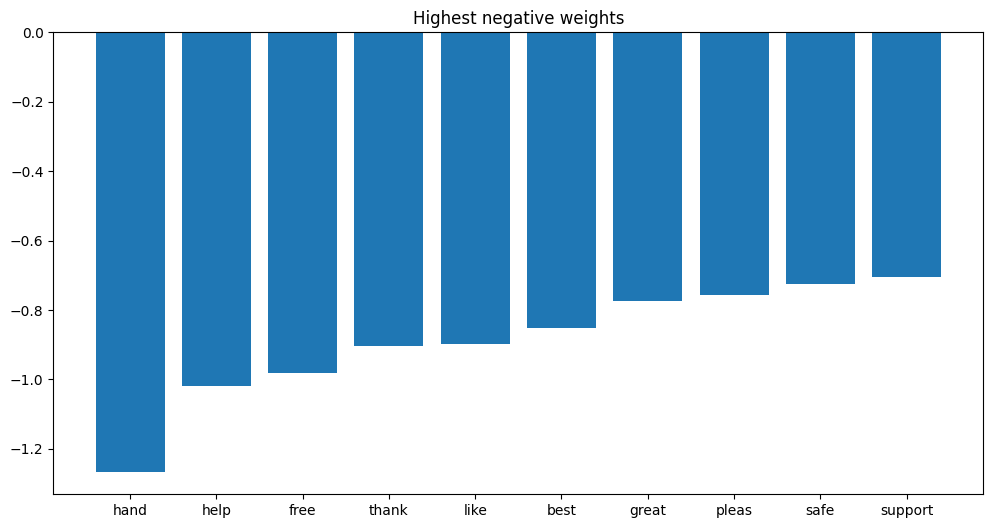

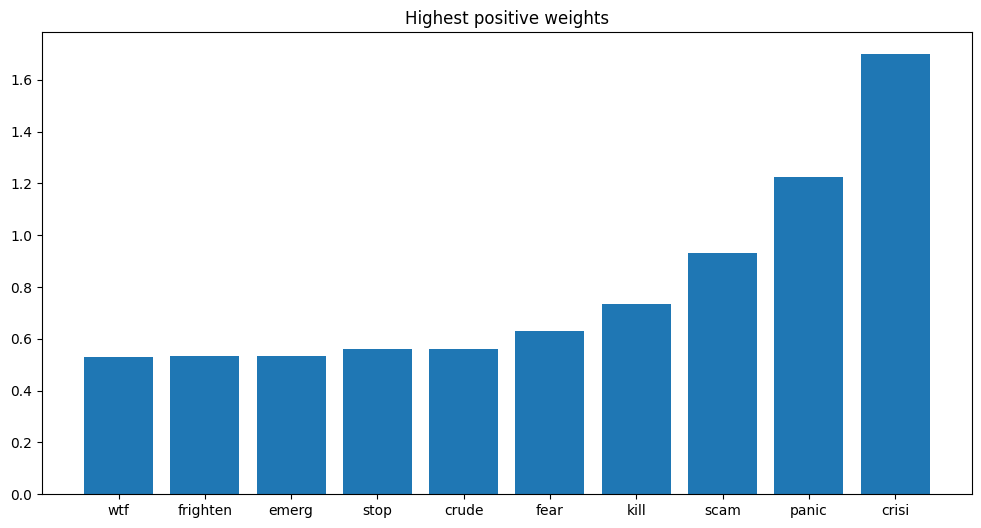

In [84]:
plt.figure(figsize=(12, 6))
plt.bar(features[top_tokens[:10]], coef[top_tokens[:10]])
plt.title('Highest negative weights')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(features[top_tokens[-10:]], coef[top_tokens[-10:]])
plt.title('Highest positive weights')
plt.show()

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [104]:
Train_new = np.column_stack((Train, train['UserName'], train['UserName']))
Test_new = np.column_stack((Test, test['UserName'], test['UserName']))


logist_reg = LogisticRegression(max_iter = 1000)
logist_reg.fit(Train_new, y)
pred = logist_reg.predict(Train_new)
accuracy = accuracy_score(y, pred)
print("Точность на тренировочной выборке:", accuracy)
pred_test = logist_reg.predict(Test_new)
accuracy = accuracy_score(y_test, pred_test)
print("Точность на тестовой выборке:", accuracy)

Точность на тренировочной выборке: 0.8171294318667236
Точность на тестовой выборке: 0.782240382698824


**Ответ:** Качество упало, возможно связано с тем, что даже если пользователь может быть "оптимистом" или "пессимистом" он все равно пишет твиты разной окраски.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

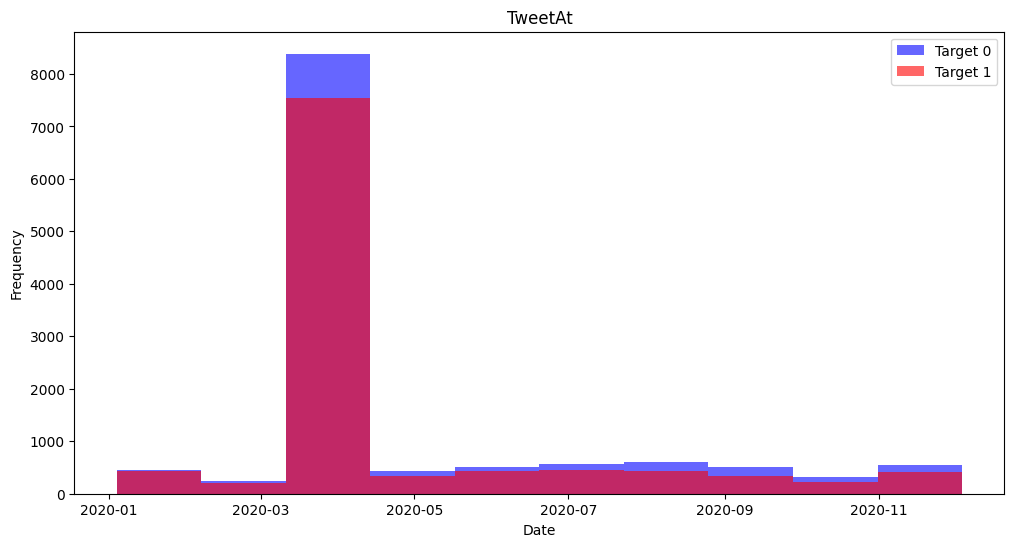

In [116]:
train['TweetAt_new'] = pd.to_datetime(train['TweetAt'], format='mixed')
plt.figure(figsize=(12, 6))
for label, color in zip([0, 1], ['b', 'r']):
    plt.hist(train[y == label]['TweetAt_new'], color=color, label=f'Target {label}', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('TweetAt')
plt.legend()
plt.show()

**Ответ:** Признак не является поленым, поскольку как мы видим каждый день основная масса твитов - положительноокрашенные твиты, негативно окрашеных 5-15%.
Более того с логической точки зрения мы можем предполагать, что в реальной жизни мы не узнаем заранее, произойдет ли какое-то плохое/хорошее событие, которое повлечет массовые публикации положительных/негативных твитов.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [160]:
df['Location'].nunique()

10465

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

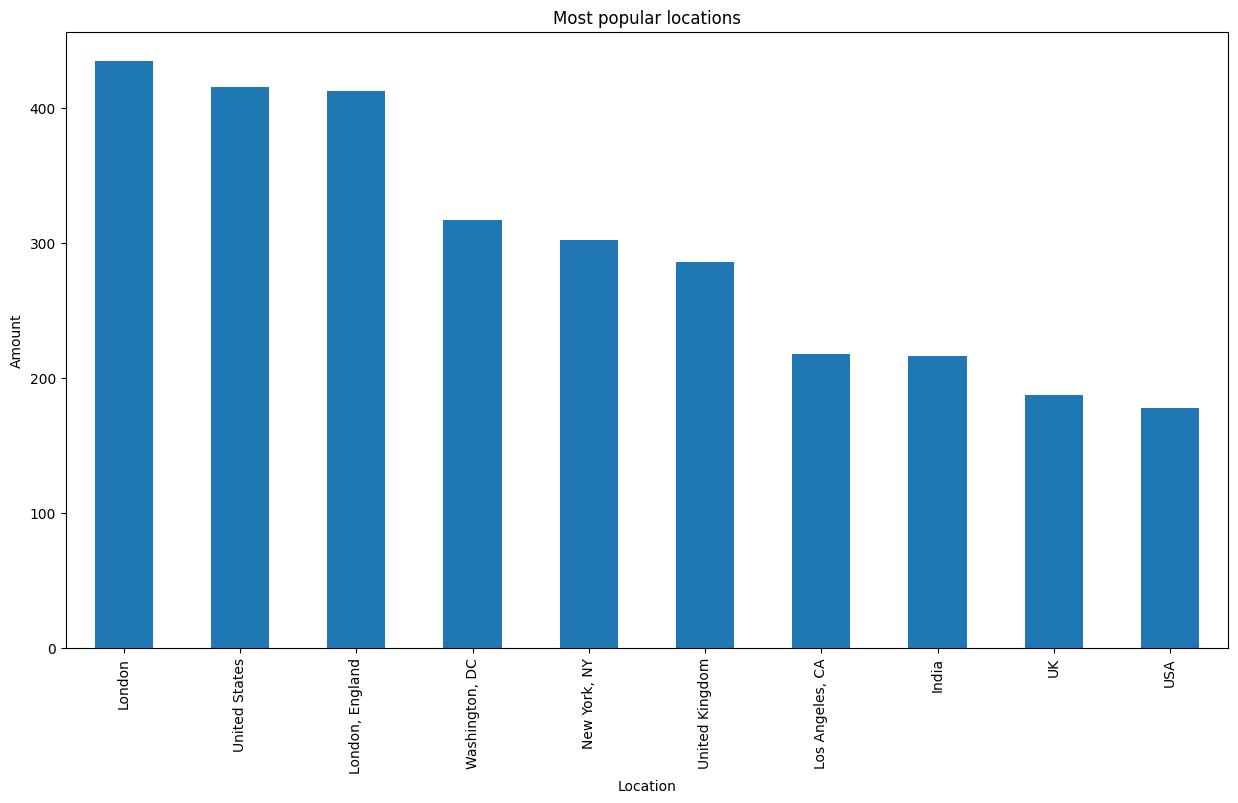

In [161]:
locations = df[df['Location'] != 'Unknown']['Location'].value_counts().head(10)

plt.figure(figsize=(15, 8))
locations.plot(kind='bar')
plt.title('Most popular locations')
plt.xlabel('Location')
plt.ylabel('Amount')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [157]:
df['WiderLocation'] = df['Location'].apply(lambda x: x.split(',')[-1].strip() if ',' in x else x)

In [158]:
df['WiderLocation'].nunique()

6305

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [162]:
res_loc = pd.get_dummies(df['WiderLocation'])

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [164]:
train_loc, test_loc = train_test_split( res_loc, test_size=0.3, random_state=0)

Train_new = np.column_stack((Train, train_loc))
Test_new = np.column_stack((Test, test_loc))


logist_reg = LogisticRegression(max_iter = 1000)
logist_reg.fit(Train_new, y)
pred = logist_reg.predict(Train_new)
accuracy = accuracy_score(y, pred)
print("Точность на тренировочной выборке:", accuracy)
pred_test = logist_reg.predict(Test_new)
accuracy = accuracy_score(y_test, pred_test)
print("Точность на тестовой выборке:", accuracy)

Точность на тренировочной выборке: 0.9459632635625801
Точность на тестовой выборке: 0.8415387681881602


Ответ: Результат немного просел по сравнению с первыми измерениями, однако лучше чем при использвании одного скалера без локации или при учитывании UserName и ScreenName. Спасибо за проверку, я очень устала и наконец-то могу пойти спать(

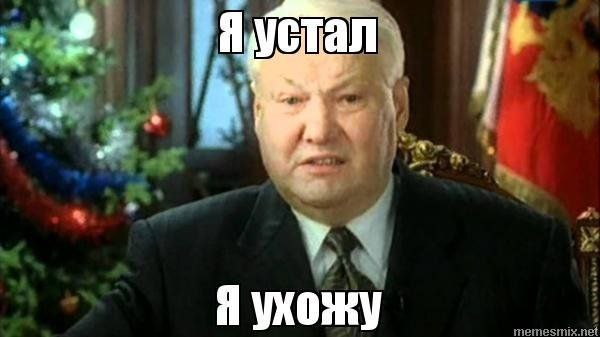

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --